# Wykrywanie wariantów DNA

na bazie 
https://app.terra.bio/#workspaces/help-gatk/GATKTutorials-Germline-June2019/notebooks/launch/1-gatk-germline-variant-discovery-tutorial.ipynb


In [2]:
#####
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://storage.googleapis.com/gatk-tutorials/workshop_1906/2-germline/images/vd-image1.png")

In [1]:
from __future__ import print_function
from IPython.core.magic import Magics, magics_class, line_magic
import subprocess
def create_new_cell(contents):
    from IPython.core.getipython import get_ipython
    shell = get_ipython()
    shell.set_next_input(contents, replace=True)

def get_solution(solution_file, solution_local):
    subprocess.call(['gsutil' ,'cp', solution_file, solution_local ])
    myfile = open(solution_local)
    lines = myfile.read()
    myfile.close()
    ! rm {solution_local}
    return lines
    


@magics_class
class MyMagics(Magics):

    @line_magic
    def lmagic(self, line):
        "Replace current line with new output"
        raw_code = get_solution("gs://bucket-edugen/"+line,line)
        self.shell.set_next_input('# %lmagic '+line+'\n{}'.format(raw_code), replace=True)
      
ip = get_ipython()
ip.register_magics(MyMagics)

## Ustawienia zmiennych

In [2]:
import os
user_name = os.environ.get('USER')
print(user_name)

workspace = "/home/jovyan/work/git/edugen_pub/"
os.environ['WORKSPACE'] = workspace
! echo ${WORKSPACE}

tgambin
/home/jovyan/work/git/edugen_pub/


In [4]:
def clean_all(): 
    ! rm -r sandbox_trio
    ! gsutil rm gs://bucket-$USER/*vcf*
    ! gsutil rm gs://bucket-$USER/*bam*

In [5]:
clean_all()

rm: cannot remove 'sandbox_trio': No such file or directory
CommandException: No URLs matched: gs://bucket-tgambin/*vcf*
CommandException: No URLs matched: gs://bucket-tgambin/*bam*


### Utworzenie własnego kubełka i jego upubliczenienie

In [3]:
! gsutil mb gs://bucket-$USER
! gsutil iam ch  allUsers:objectViewer gs://bucket-$USER

Creating gs://bucket-tgambin/...
ServiceException: 409 Bucket bucket-tgambin already exists.
No changes made to gs://bucket-tgambin/


## Wykrywanie wariantów GATK HaplotypeCaller w trybie standardowym

Wywolanie GATK HC w najprostszej wersji dla pojedynczej próbki

In [8]:
! gatk HaplotypeCaller \
    -R ${WORKSPACE}/ref/ref.fasta \
    -I ${WORKSPACE}/bam/mother.bam \
    -O ${WORKSPACE}/sandbox/motherHC.vcf \
    -L 20:10,000,000-10,200,000

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar HaplotypeCaller -R /home/jovyan/work/git/edugen_pub//ref/ref.fasta -I /home/jovyan/work/git/edugen_pub//bam/mother.bam -O /home/jovyan/work/git/edugen_pub//sandbox/motherHC.vcf -L 20:10,000,000-10,200,000
22:05:55.585 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:05:56.330 INFO  HaplotypeCaller - ------------------------------------------------------------
22:05:56.330 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:05:56.330 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
22:05:56.330 INFO  HaplotypeCall

## Wizualizacja BAM i VCF w programie IGV

### Skopiowanie do publicznego kubełka

In [9]:
! bgzip -c ${WORKSPACE}/sandbox/motherHC.vcf > ${WORKSPACE}/sandbox/motherHC.vcf.gz
! tabix ${WORKSPACE}/sandbox/motherHC.vcf.gz
! gsutil cp sandbox/motherHC.vcf.gz* gs://bucket-$USER/

Copying file://sandbox/motherHC.vcf.gz [Content-Type=text/vcard]...
Copying file://sandbox/motherHC.vcf.gz.tbi [Content-Type=application/octet-stream]...
- [2 files][ 18.1 KiB/ 18.1 KiB]                                                
Operation completed over 2 objects/18.1 KiB.                                     


<div class="alert alert-block alert-warning">
<b>Zadanie 1*:</b> Skopiuj plik bam i bai do swojego kubełka  
</div>

### Uruchomienie IGV

In [4]:
from igv_jupyterlab import IGV
# At minimum, IGV requires a single argument, genome.
# For supported genomes, a simple name may be supplied.
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)
t1 = igv.create_track(
        name = "mother BAM",
        url = "gs://bucket-"+user_name+"/mother.bam",
        index_url= "gs://bucket-"+user_name+"/mother.bam.bai",        
        indexed= True
)

t2 = igv.create_track(
        name= "mother HC VCF",
        url= "gs://bucket-"+user_name+"/motherHC.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/motherHC.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)
igv.load_track(t1)
igv.load_track(t2)
igv.search_locus("20", 10002294, 10002623)


IGV(id='igv_9478132', initialConfig={'id': 'igv_9478132', 'locus': '', 'genome': 'hg19'})

In [7]:
! zcat ${WORKSPACE}/sandbox/motherHC.vcf.gz | grep 100024

20	10002458	.	G	GTTT	613.06	.	AC=2;AF=1.00;AN=2;DP=20;ExcessHet=3.0103;FS=0.000;MLEAC=1;MLEAF=0.500;MQ=60.00;QD=25.00;SOR=1.329	GT:AD:DP:GQ:PL	1/1:0,17:17:50:612,50,0
20	10002470	.	C	T	761.06	.	AC=2;AF=1.00;AN=2;DP=22;ExcessHet=3.0103;FS=0.000;MLEAC=2;MLEAF=1.00;MQ=60.00;QD=29.56;SOR=1.230	GT:AD:DP:GQ:PL	1/1:0,21:21:63:775,63,0


<div class="alert alert-block alert-warning">
<b>Zadanie 2:</b> Jaka jest zygotyczność dwóch widocznych wariantów? Czy jest ona zgodna z tym co widzimy w odczytach ? 
</div>

<div class="alert alert-block alert-warning">
<b>Zadanie 3:</b> Kliknij na ikonę edycji track'u z odczytami i zaznacz opcję "Soft clip reads". Algorytm mapowania (BWA MEM) zdecydował, że kara za obcięcie odczytów (Soft clipping) będzie mniejsza niż wstawienie insersji/delecji. 
</div>



- Czym jest PL, GQ: https://gatk.broadinstitute.org/hc/en-us/articles/360035890451-Calculation-of-PL-and-GQ-by-HaplotypeCaller-and-GenotypeGVCFs

## Ponowne uliniowienie odczytów i zasemblowane haplotypy

HaplotypeCaller posiada parametr -bamout pozwalający na wyświetlenie ponownie uliniowionych odczytów,
które następnie są wykorzystywane do wykrywania wariantów.


In [8]:
! gatk HaplotypeCaller \
    -R ${WORKSPACE}/ref/ref.fasta \
    -I ${WORKSPACE}/bam/mother.bam\
    -O ${WORKSPACE}/sandbox/motherHCdebug.vcf \
    -bamout ${WORKSPACE}/sandbox/motherHCdebug.bam \
    -L 20:10,002,000-10,003,000

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar HaplotypeCaller -R /home/jovyan/work/git/edugen_pub//ref/ref.fasta -I /home/jovyan/work/git/edugen_pub//bam/mother.bam -O /home/jovyan/work/git/edugen_pub//sandbox/motherHCdebug.vcf -bamout /home/jovyan/work/git/edugen_pub//sandbox/motherHCdebug.bam -L 20:10,002,000-10,003,000
22:31:05.080 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:31:05.826 INFO  HaplotypeCaller - ------------------------------------------------------------
22:31:05.827 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:31:05.827 INFO  HaplotypeCaller - For support and documentation go to h

<div class="alert alert-block alert-warning">
<b>Zadanie 4*:</b> Wyświetl dla porównania obydwa BAMy (zwykły i debug) oraz VCF. Przy wyświetlaniu BAM'ów ustaw opcję 
    showSoftClips = True, aby od razu wyświetlały się split ready. Inne opcje są dostępne na: https://github.com/igvteam/igv.js/wiki/Alignment-Track
</div>

Ponieważ jesteśmy zainteresowani jednym miejscem (20:10,002,000-10,003,000) to dokonaliśmy reuliniowienia tylko tego fragmentu. 

Po ponownym uliniowieniu zniknęły obcięte odczyty (soft clipped reads) . HaplotypeCaller wykorzystuje odczyty 'soft-clipped' do ponownego uliniowienia. Z analizy odczytów wynika, że insercja i pobliski SNP są ze sobą sfazowane. Wynika z tego, że HaplotypeCaller znalazł różne możliwe uliniowienia po wykonaniu lokalnej reasemblacji. Po reasemblacji występuje wystarczająco dużo odczytów wskazujących na występowanie insercji, która byłaby pominięta w przypadku użycia prostszych algorytmów, nie wykorzystujących reasemblacji (np. UnifiedGenotyper)

<div class="alert alert-block alert-warning">
<b>Zadanie 5:</b> Przyjrzyj się insercji w poszczególnych odczytach.  Czy wszędzie jest ona taka sama?
</div>

<div class="alert alert-block alert-warning">
<b>Zadanie 6*:</b> W jaki sposób wyświetlić w IGV haplotypy utworzone przez HC?
</div>

Czerwone odczyty nie są prawdziwe - (spójrz na RG). Są to odczyty reprezentujące haplotypy utworzone przez HaplotypeCaller. Co jeżeli pokolorujemy po tagu HC?
<div class="alert alert-block alert-warning">
<b>Zadanie 7:</b> Podejrzyj wsparcie dla każdego haplotypu poprzez pokolorowanie po tag'u HC zamiast RG. HaplotypeCaller oznacza odpowiednim tagiem HC wszystkie odczyty jednoznacznie wskazujący na dany "sztuczny haplotyp". Co teraz sądzisz o decyzji Variant Caller'a w sprawie wyboru typu insercji?
</div>

<div class="alert alert-block alert-warning">
<b>Zadanie 8:</b> Oddal widok i zobacz ile różnych haplotypów zostało znalezionych dla kolejnych trzech spójnych regionów. Dlaczego w regionie po lewej jest więcej haplotypów?
</div>

## Jednoczesne genotypowanie wielu próbek przy wykorzystaniu gVCF

Istnieje możliwość jednoczesnego genotypowania wielu probek w normalnym trybie pracy działania HaplotypeCallera (joint calling). Jednakże nie jest to rozwiązanie skalowalne. Dlatego rozdzielono przetwarzanie plików BAM od właściwego genotypowania poprzez wprowadzenie tzw. plików gVCF. 

W trybie potoku GVCF HaplotypeCaller urachmiany jest z opcją -ERC GVCF dla każdego pliku BAM, co w wyniku generuje pliki z rozszerzeniem .gvcf posiadające poza informacją o wariantach dodatkowe dane o jakości pozostałych regionów. Następnie jednoczesne genotypowanie wielu próbek odbywa się poprzez wykonanie metody GenotypeGVCF na wielu plikach gvcf. 

Utwórzmy plik g.vcf dla jednego pliku bam (mother.bam).

In [14]:
! gatk HaplotypeCaller \
    -R ${WORKSPACE}/ref/ref.fasta \
    -I ${WORKSPACE}/bam/mother.bam \
    -O ${WORKSPACE}/sandbox/motherHC.g.vcf \
    -ERC GVCF \
    -L 20:10,000,000-10,200,000

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar HaplotypeCaller -R /home/jovyan/work/git/edugen_pub//ref/ref.fasta -I /home/jovyan/work/git/edugen_pub//bam/mother.bam -O /home/jovyan/work/git/edugen_pub//sandbox/motherHC.g.vcf -ERC GVCF -L 20:10,000,000-10,200,000
22:35:38.877 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:35:39.588 INFO  HaplotypeCaller - ------------------------------------------------------------
22:35:39.588 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:35:39.588 INFO  HaplotypeCaller - For support and documentation go to https://software.broadinstitute.org/gatk/
22:35:39.589 INFO  H

In [15]:
! bgzip -c ${WORKSPACE}/sandbox/motherHC.g.vcf > ${WORKSPACE}/sandbox/motherHC.g.vcf.gz
! tabix ${WORKSPACE}/sandbox/motherHC.g.vcf.gz
! gsutil cp sandbox/motherHC.g.vcf* gs://bucket-$USER/

Copying file://sandbox/motherHC.g.vcf [Content-Type=text/vcard]...
Copying file://sandbox/motherHC.g.vcf.gz [Content-Type=text/vcard]...           
Copying file://sandbox/motherHC.g.vcf.gz.tbi [Content-Type=application/octet-stream]...
Copying file://sandbox/motherHC.g.vcf.idx [Content-Type=application/octet-stream]...
\ [4 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 4 objects/5.3 MiB.                                      


In [16]:
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)


t2 = igv.create_track(
        name= "mother HC debug BAM",
        url= "gs://bucket-"+user_name+"/motherHCdebug.bam",
        index_url= "gs://bucket-"+user_name+"/motherHCdebug.bai",
        indexed= True,
        showSoftClips=True,
        colorBy="tag",
        colorByTag= "HC",
        sortByTag= "RG",
        visibilityWindow= 1000
)
t3 = igv.create_track(
        name= "mother HC VCF",
        url= "gs://bucket-"+user_name+"/motherHC.g.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/motherHC.g.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)
igv.load_track(t2)

igv.load_track(t3)
igv.search_locus("20", 10002294, 10002623)

IGV(id='igv_804271', initialConfig={'id': 'igv_804271', 'locus': '', 'genome': 'hg19'})

Co sie zmienilo w stosunku do VCF?
Poza wariantami pojawily sie szare bloki reprezentujace stopien pewnosci, ze w danym regionie nie ma wariantu. 
Zmiana bloku oznacza zmiane pewnosci, ze w danym regionie nie ma wariantow. 


In [17]:
# Podejrzyj kilka wierszy g.vcf
! zcat ${WORKSPACE}/sandbox/motherHC.g.vcf.gz |  grep 10002458

20	10002458	.	G	GTT,GTTT,<NON_REF>	613.06	.	DP=20;ExcessHet=3.0103;MLEAC=1,1,0;MLEAF=0.500,0.500,0.00;RAW_MQandDP=72000,20	GT:AD:DP:GQ:PL:SB	1/2:0,2,6,0:8:18:630,125,74,68,0,18,420,122,66,373:0,0,4,4


Jeżeli podejrzymy zawartość gVCF, to zobaczymy, że w kolumnie ALT pojawia się pozycja \<NON_REF\>.
Identyfikator PL w kolumnie format oznacza prawdopodobieństwo występowania kolejnych alleli, włączając \<NON_REF\>. 


### Import gvcf dla trio do specjalnej bazy danych (GenomicsDB)

In [18]:
!mkdir sandbox_trio
! gatk GenomicsDBImport \
    -V ${WORKSPACE}/gvcf/mother.g.vcf.gz \
    -V ${WORKSPACE}/gvcf/father.g.vcf.gz \
    -V ${WORKSPACE}/gvcf/son.g.vcf.gz \
    --genomicsdb-workspace-path ${WORKSPACE}/sandbox_trio/trio \
    --intervals 20:10,000,000-10,200,000

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar GenomicsDBImport -V /home/jovyan/work/git/edugen_pub//gvcf/mother.g.vcf.gz -V /home/jovyan/work/git/edugen_pub//gvcf/father.g.vcf.gz -V /home/jovyan/work/git/edugen_pub//gvcf/son.g.vcf.gz --genomicsdb-workspace-path /home/jovyan/work/git/edugen_pub//sandbox_trio/trio --intervals 20:10,000,000-10,200,000
22:40:06.367 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:40:07.142 INFO  GenomicsDBImport - ------------------------------------------------------------
22:40:07.143 INFO  GenomicsDBImport - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:40:07.143 INFO  GenomicsDBImport - For sup

In [ ]:
#! ln -s ${WORKSPACE}/sandbox_trio/ sandbox_trio

In [19]:
# z bazy mozemy wyciagnac polaczony gvcf
! gatk SelectVariants \
    -R ${WORKSPACE}/ref/ref.fasta \
    -V gendb://sandbox_trio/trio \
    -O ${WORKSPACE}/sandbox/trio_selectvariants.g.vcf

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar SelectVariants -R /home/jovyan/work/git/edugen_pub//ref/ref.fasta -V gendb://sandbox_trio/trio -O /home/jovyan/work/git/edugen_pub//sandbox/trio_selectvariants.g.vcf
22:40:37.513 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:40:38.257 INFO  SelectVariants - ------------------------------------------------------------
22:40:38.258 INFO  SelectVariants - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:40:38.258 INFO  SelectVariants - For support and documentation go to https://software.broadinstitute.org/gatk/
22:40:38.258 INFO  SelectVariants - Executing as jovyan@jupyter-tgambin on

<b>ALE warianty na tym etapie nie mają wyliczonych genotypów</b>

In [20]:
! cat ${WORKSPACE}/sandbox/trio_selectvariants.g.vcf | grep 10002458

20	10002458	.	G	GTT,GTTT,<NON_REF>	.	.	DP=54;ExcessHet=3.0103;RAW_MQandDP=100800,28	GT:AD:DP:GQ:MIN_DP:PGT:PID:PL:SB	./.:.:26:42:26:.:.:0,42,630,42,630,630,42,630,630,630	./.:0,2,5,0:7:18:.:.:.:630,125,74,68,0,18,420,122,66,373:0,0,4,3	./.:0,5,0,0:5:21:.:0|1:10002458_G_GTT:191,21,0,191,21,191,191,21,191,191:0,0,4,1
20	10002470	.	C	T,<NON_REF>	.	.	DP=56;ExcessHet=3.0103;RAW_MQandDP=108000,30	GT:AD:DP:GQ:MIN_DP:PGT:PID:PL:SB	./.:.:26:0:26:.:.:0,0,0,0,0,0	./.:0,20,0:20:63:.:.:.:774,63,0,774,63,774:0,0,8,12	./.:0,10,0:10:30:.:0|1:10002458_G_GTT:377,30,0,377,30,377:0,0,5,5


Dlatego ostatnim krokiem jest genotyopwanie

In [21]:
! gatk GenotypeGVCFs \
    -R ${WORKSPACE}/ref/ref.fasta \
    -V gendb://sandbox_trio/trio \
    -O ${WORKSPACE}/sandbox/trioGGVCF.vcf \
    -L 20:10,000,000-10,200,000

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar GenotypeGVCFs -R /home/jovyan/work/git/edugen_pub//ref/ref.fasta -V gendb://sandbox_trio/trio -O /home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf -L 20:10,000,000-10,200,000
22:42:38.962 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:42:39.655 INFO  GenotypeGVCFs - ------------------------------------------------------------
22:42:39.655 INFO  GenotypeGVCFs - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:42:39.655 INFO  GenotypeGVCFs - For support and documentation go to https://software.broadinstitute.org/gatk/
22:42:39.655 INFO  GenotypeGVCFs - Executing as jovyan@jupyter

In [22]:
! bgzip -c ${WORKSPACE}/sandbox/trioGGVCF.vcf > ${WORKSPACE}/sandbox/trioGGVCF.vcf.gz
! tabix ${WORKSPACE}/sandbox/trioGGVCF.vcf.gz
! gsutil cp sandbox/trioGGVCF.vcf.gz* gs://bucket-$USER/

Copying file://sandbox/trioGGVCF.vcf.gz [Content-Type=text/vcard]...
Copying file://sandbox/trioGGVCF.vcf.gz.tbi [Content-Type=application/octet-stream]...
- [2 files][ 39.1 KiB/ 39.1 KiB]                                                
Operation completed over 2 objects/39.1 KiB.                                     


In [23]:
from igv_jupyterlab import IGV
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)


t3 = igv.create_track(
        name= "trio VCF",
        url= "gs://bucket-"+user_name+"/trioGGVCF.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/trioGGVCF.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)

igv.load_track(t3)

igv.search_locus("20", 10002294, 10002623)

IGV(id='igv_3028454', initialConfig={'id': 'igv_3028454', 'locus': '', 'genome': 'hg19'})

# Poprawa genotypowania

In [24]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://us.v-cdn.net/5019796/uploads/FileUpload/40/a04b64d7884a07d1b562ead4002c60.jpg")

In [25]:
! gatk CalculateGenotypePosteriors \
    -V ${WORKSPACE}/sandbox/trioGGVCF.vcf \
    -ped ${WORKSPACE}/trio.ped \
    --skip-population-priors \
    -O ${WORKSPACE}/sandbox/trioCGP.vcf

gzip: /home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf: unknown suffix -- ignored
Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar CalculateGenotypePosteriors -V /home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf -ped /home/jovyan/work/git/edugen_pub//trio.ped --skip-population-priors -O /home/jovyan/work/git/edugen_pub//sandbox/trioCGP.vcf
22:45:10.556 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:45:11.284 INFO  CalculateGenotypePosteriors - ------------------------------------------------------------
22:45:11.285 INFO  CalculateGenotypePosteriors - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:45:11.285 INFO  Cal

In [26]:
! gatk CalculateGenotypePosteriors \
    -V ${WORKSPACE}/sandbox/trioGGVCF.vcf \
    -ped ${WORKSPACE}/trio.ped \
    --supporting-callsets ${WORKSPACE}/resources/af-only-gnomad.chr20subset.b37.vcf.gz \
    -O ${WORKSPACE}/sandbox/trioCGP_gnomad.vcf

Using GATK jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar CalculateGenotypePosteriors -V /home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf -ped /home/jovyan/work/git/edugen_pub//trio.ped --supporting-callsets /home/jovyan/work/git/edugen_pub//resources/af-only-gnomad.chr20subset.b37.vcf.gz -O /home/jovyan/work/git/edugen_pub//sandbox/trioCGP_gnomad.vcf
22:46:37.349 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/opt/gatk-4.1.9.0/gatk-package-4.1.9.0-local.jar!/com/intel/gkl/native/libgkl_compression.so
22:46:38.073 INFO  CalculateGenotypePosteriors - ------------------------------------------------------------
22:46:38.074 INFO  CalculateGenotypePosteriors - The Genome Analysis Toolkit (GATK) v4.1.9.0
22:46:38.074 INFO  Calcul

In [29]:
! bgzip -c  ${WORKSPACE}/sandbox/trioGGVCF.vcf > ${WORKSPACE}/sandbox/trioGGVCF.vcf.gz
! tabix -f ${WORKSPACE}/sandbox/trioGGVCF.vcf.gz
! bgzip -c  ${WORKSPACE}/sandbox/trioCGP.vcf > ${WORKSPACE}/sandbox/trioCGP.vcf.gz
! tabix -f ${WORKSPACE}/sandbox/trioCGP.vcf.gz
! bgzip -c  ${WORKSPACE}/sandbox/trioCGP_gnomad.vcf > ${WORKSPACE}/sandbox/trioCGP_gnomad.vcf.gz
! tabix -f ${WORKSPACE}/sandbox/trioCGP_gnomad.vcf.gz
! gsutil cp  ${WORKSPACE}/sandbox/trioGGVCF* gs://bucket-$USER/
! gsutil cp  ${WORKSPACE}/sandbox/trioCGP* gs://bucket-$USER/


Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf [Content-Type=text/vcard]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf.gz [Content-Type=text/vcard]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf.gz.tbi [Content-Type=application/octet-stream]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioGGVCF.vcf.idx [Content-Type=application/octet-stream]...
\ [4 files][216.9 KiB/216.9 KiB]                                                
Operation completed over 4 objects/216.9 KiB.                                    
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioCGP_gnomad.vcf [Content-Type=text/vcard]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioCGP_gnomad.vcf.gz [Content-Type=text/vcard]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox/trioCGP_gnomad.vcf.gz.tbi [Content-Type=application/octet-stream]...
Copying file:///home/jovyan/work/git/edugen_pub//sandbox

In [30]:
!gsutil ls "gs://bucket-"$USER

gs://bucket-tgambin/README.md
gs://bucket-tgambin/mother.bam
gs://bucket-tgambin/mother.bam.bai
gs://bucket-tgambin/motherHC.g.vcf
gs://bucket-tgambin/motherHC.g.vcf.gz
gs://bucket-tgambin/motherHC.g.vcf.gz.tbi
gs://bucket-tgambin/motherHC.g.vcf.idx
gs://bucket-tgambin/motherHC.vcf.gz
gs://bucket-tgambin/motherHC.vcf.gz.tbi
gs://bucket-tgambin/motherHCdebug.bai
gs://bucket-tgambin/motherHCdebug.bam
gs://bucket-tgambin/pop2.csv
gs://bucket-tgambin/trio.ped
gs://bucket-tgambin/trioCGP.vcf
gs://bucket-tgambin/trioCGP.vcf.gz
gs://bucket-tgambin/trioCGP.vcf.gz.tbi
gs://bucket-tgambin/trioCGP.vcf.idx
gs://bucket-tgambin/trioCGP_gnomad.vcf
gs://bucket-tgambin/trioCGP_gnomad.vcf.gz
gs://bucket-tgambin/trioCGP_gnomad.vcf.gz.tbi
gs://bucket-tgambin/trioCGP_gnomad.vcf.idx
gs://bucket-tgambin/trioGGVCF.vcf
gs://bucket-tgambin/trioGGVCF.vcf.gz
gs://bucket-tgambin/trioGGVCF.vcf.gz.tbi
gs://bucket-tgambin/trioGGVCF.vcf.idx


In [31]:
from igv_jupyterlab import IGV
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)


t1 = igv.create_track(
        name= "trio GVCF",
        url= "gs://bucket-"+user_name+"/trioGGVCF.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/trioGGVCF.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)

t2 = igv.create_track(
        name= "trio CGP",
        url= "gs://bucket-"+user_name+"/trioCGP.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/trioCGP.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)


t3 = igv.create_track(
        name= "trio CGP gnomad",
        url= "gs://bucket-"+user_name+"/trioCGP_gnomad.vcf.gz",
        index_url= "gs://bucket-"+user_name+"/trioCGP_gnomad.vcf.gz.tbi",
        indexed= True,
        visibilityWindow= 1000
)


igv.load_track(t1)
igv.load_track(t2)
igv.load_track(t3)

igv.search_locus("20", 10002294, 10002623)


IGV(id='igv_2021251', initialConfig={'id': 'igv_2021251', 'locus': '', 'genome': 'hg19'})

CalculateGenotypePosteriors dodaje 3 pozycje do kolumny FORMAT: PP, JL i JP.

- Phred-scaled Posterior Probability (PP) basically refines the PL values. It incorporates the prior expectations for the given pedigree and/or population allele frequencies.
- Joint Trio Likelihood (JL) is the Phred-scaled joint likelihood of the posterior genotypes for the trio being incorrect.
- Joint Trio Posterior (JP) is the Phred-scaled posterior probability of the posterior genotypes for the three samples being incorrect.

In [32]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://storage.googleapis.com/gatk-tutorials/workshop_1906/2-germline/images/vd-image4.png")


In [33]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://storage.googleapis.com/gatk-tutorials/workshop_1906/2-germline/images/vd-image5.png")


Więcej szczegółów na https://gatk.broadinstitute.org/hc/en-us/articles/360035531432?id=11074

# Analiza pokrycia

In [34]:
import os
import pysam
counter = 0
with pysam.AlignmentFile(workspace+'/bam/mother.bam', 'rb') as samfile:
    for pileupcolumn in samfile.pileup("20", 10002294, 10002303):
        counter +=1;
        #if (pileupcolumn.pos != 16099988):   continue;
        print ("\ncoverage at base %s = %s" % (pileupcolumn.pos, pileupcolumn.n))
        if (counter > 10): break


coverage at base 10002145 = 1

coverage at base 10002146 = 1

coverage at base 10002147 = 1

coverage at base 10002148 = 2

coverage at base 10002149 = 3

coverage at base 10002150 = 4

coverage at base 10002151 = 6

coverage at base 10002152 = 6

coverage at base 10002153 = 7

coverage at base 10002154 = 7

coverage at base 10002155 = 8


In [35]:
! samtools depth -a -r 20:10002294-10002623   ${WORKSPACE}/bam/mother.bam -o ${WORKSPACE}/sandbox/mother_cov

[W::hts_idx_load3] The index file is older than the data file: /home/jovyan/work/git/edugen_pub//bam/mother.bam.bai


In [36]:
! head  ${WORKSPACE}/sandbox/mother_cov

20	10002294	41
20	10002295	42
20	10002296	42
20	10002297	41
20	10002298	41
20	10002299	41
20	10002300	40
20	10002301	40
20	10002302	40
20	10002303	38


In [37]:
import pandas as pd
tsv_read = pd.read_csv(workspace+'/sandbox/mother_cov', sep='\t' , header=None)

In [38]:
tsv_read.columns = ["chr", "start", "coverage"]
tsv_read

,chr,start,coverage
0,20,10002294,41
1,20,10002295,42
2,20,10002296,42
3,20,10002297,41
4,20,10002298,41
...,...,...,...
325,20,10002619,34
326,20,10002620,34
327,20,10002621,34
328,20,10002622,33


<div class="alert alert-block alert-warning">
<b>Zadanie 9*:</b> Zrób wykres głębokości pokrycia dla pozycji (chr20:10002294-10002623)i porównaj go z wizualizacja w IGV.
</div>

# Adnotacje

In [40]:
from biothings_client import get_client
import pandas as pd
pd.set_option('display.max_columns', 2000)
mv = get_client('variant')
mv.getvariants(["chr7:g.140453134T>C","chr7:g.140453134T>C"], as_dataframe=1)

querying 1-2...done.


/tmp/jovyan/venv/edugen/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


,_id,_version,chrom,observed,cadd._license,cadd.alt,cadd.anc,cadd.annotype,cadd.bstatistic,cadd.chmm.bivflnk,cadd.chmm.enh,cadd.chmm.enhbiv,cadd.chmm.het,cadd.chmm.quies,cadd.chmm.reprpc,cadd.chmm.reprpcwk,cadd.chmm.tssa,cadd.chmm.tssaflnk,cadd.chmm.tssbiv,cadd.chmm.tx,cadd.chmm.txflnk,cadd.chmm.txwk,cadd.chmm.znfrpts,cadd.chrom,cadd.consdetail,cadd.consequence,cadd.consscore,cadd.cpg,cadd.dna.helt,cadd.dna.mgw,cadd.dna.prot,cadd.dna.roll,cadd.encode.exp,cadd.encode.h3k27ac,cadd.encode.h3k4me1,cadd.encode.h3k4me3,cadd.encode.nucleo,cadd.exon,cadd.fitcons,cadd.gc,cadd.gene.ccds_id,cadd.gene.cds.cdna_pos,cadd.gene.cds.cds_pos,cadd.gene.cds.rel_cdna_pos,cadd.gene.cds.rel_cds_pos,cadd.gene.feature_id,cadd.gene.gene_id,cadd.gene.genename,cadd.gene.prot.domain,cadd.gene.prot.protpos,cadd.gene.prot.rel_prot_pos,cadd.gerp.n,cadd.gerp.rs,cadd.gerp.rs_pval,cadd.gerp.s,cadd.grantham,cadd.isderived,cadd.isknownvariant,cadd.istv,cadd.length,cadd.mapability.20bp,cadd.mapability.35bp,cadd.min_dist_tse,cadd.min_dist_tss,cadd.mutindex,cadd.naa,cadd.oaa,cadd.phast_cons.mammalian,cadd.phast_cons.primate,cadd.phast_cons.vertebrate,cadd.phred,cadd.phylop.mammalian,cadd.phylop.primate,cadd.phylop.vertebrate,cadd.polyphen.cat,cadd.polyphen.val,cadd.pos,cadd.rawscore,cadd.ref,cadd.segway,cadd.sift.cat,cadd.sift.val,cadd.type,civic._license,civic.allele_registry_hgvs,civic.allele_registry_id,civic.civic_actionability_score,civic.clinvar_entries,civic.coordinates.chromosome,civic.coordinates.ensembl_version,civic.coordinates.reference_bases,civic.coordinates.reference_build,civic.coordinates.representative_transcript,civic.coordinates.start,civic.coordinates.stop,civic.coordinates.variant_bases,civic.entrez_id,civic.entrez_name,civic.evidence_items,civic.gene_id,civic.hgvs_expressions,civic.lifecycle_actions.last_commented_on.organization.description,civic.lifecycle_actions.last_commented_on.organization.id,civic.lifecycle_actions.last_commented_on.organization.name,civic.lifecycle_actions.last_commented_on.organization.parent.description,civic.lifecycle_actions.last_commented_on.organization.parent.id,civic.lifecycle_actions.last_commented_on.organization.parent.name,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x128,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x14,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x256,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x32,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x64,civic.lifecycle_actions.last_commented_on.organization.parent.url,civic.lifecycle_actions.last_commented_on.organization.profile_image.x128,civic.lifecycle_actions.last_commented_on.organization.profile_image.x14,civic.lifecycle_actions.last_commented_on.organization.profile_image.x256,civic.lifecycle_actions.last_commented_on.organization.profile_image.x32,civic.lifecycle_actions.last_commented_on.organization.profile_image.x64,civic.lifecycle_actions.last_commented_on.organization.url,civic.lifecycle_actions.last_commented_on.timestamp,civic.lifecycle_actions.last_commented_on.user.area_of_expertise,civic.lifecycle_actions.last_commented_on.user.avatar_url,civic.lifecycle_actions.last_commented_on.user.avatars.x128,civic.lifecycle_actions.last_commented_on.user.avatars.x14,civic.lifecycle_actions.last_commented_on.user.avatars.x32,civic.lifecycle_actions.last_commented_on.user.avatars.x64,civic.lifecycle_actions.last_commented_on.user.bio,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.coi_valid,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.coi_present,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.coi_statement,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.created_at,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.expires_at,civic.lifecycle_actions.last_com

In [41]:
list(mv.query('dbnsfp.genename:CDK2', fetch_all=True))[0]
#http://docs.myvariant.info/en/latest/doc/data.html#available-fields

Fetching 2458 variant(s) . . .
No more results to return.


{'_id': 'chr12:g.56362628C>T',
 '_score': 10.831787,
 'cadd': {'_license': 'http://bit.ly/2TIuab9',
  'alt': 'T',
  'anc': 'C',
  'annotype': 'CodingTranscript',
  'bstatistic': 250,
  'chmm': {'bivflnk': 0.0,
   'enh': 0.071,
   'enhbiv': 0.0,
   'het': 0.0,
   'quies': 0.055,
   'reprpc': 0.0,
   'reprpcwk': 0.0,
   'tssa': 0.008,
   'tssaflnk': 0.0,
   'tssbiv': 0.0,
   'tx': 0.173,
   'txflnk': 0.039,
   'txwk': 0.638,
   'znfrpts': 0.0},
  'chrom': 12,
  'consdetail': 'missense',
  'consequence': 'NON_SYNONYMOUS',
  'consscore': 7,
  'cpg': 0.03,
  'dna': {'helt': 1.76, 'mgw': 0.15, 'prot': -2.07, 'roll': 0.38},
  'encode': {'exp': 332.0,
   'h3k27ac': 5.08,
   'h3k4me1': 11.76,
   'h3k4me3': 21.2,
   'nucleo': 2.8},
  'exon': '4/7',
  'fitcons': 0.701516,
  'gc': 0.51,
  'gene': {'ccds_id': 'CCDS8898.1',
   'cds': {'cdna_pos': 622,
    'cds_pos': 382,
    'rel_cdna_pos': 0.27,
    'rel_cds_pos': 0.43},
   'feature_id': 'ENST00000266970',
   'gene_id': 'ENSG00000123374',
   'genen

In [42]:
#mv.getvariants('chr17:g.7578532A>G', fields = ['clinvar','gnomad_af'] , as_dataframe=1)
gg = mv.getvariants('chr7:g.140453134T>C', fields = "all" , as_dataframe=1)
gg.shape
gg

#https://cdn.rawgit.com/biothings/myvariant.info/master/docs/ipynb/myvariant_clinvar_demo.html

querying 1-1...done.


/tmp/jovyan/venv/edugen/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


,_id,_version,chrom,observed,cadd._license,cadd.alt,cadd.anc,cadd.annotype,cadd.bstatistic,cadd.chmm.bivflnk,cadd.chmm.enh,cadd.chmm.enhbiv,cadd.chmm.het,cadd.chmm.quies,cadd.chmm.reprpc,cadd.chmm.reprpcwk,cadd.chmm.tssa,cadd.chmm.tssaflnk,cadd.chmm.tssbiv,cadd.chmm.tx,cadd.chmm.txflnk,cadd.chmm.txwk,cadd.chmm.znfrpts,cadd.chrom,cadd.consdetail,cadd.consequence,cadd.consscore,cadd.cpg,cadd.dna.helt,cadd.dna.mgw,cadd.dna.prot,cadd.dna.roll,cadd.encode.exp,cadd.encode.h3k27ac,cadd.encode.h3k4me1,cadd.encode.h3k4me3,cadd.encode.nucleo,cadd.exon,cadd.fitcons,cadd.gc,cadd.gene.ccds_id,cadd.gene.cds.cdna_pos,cadd.gene.cds.cds_pos,cadd.gene.cds.rel_cdna_pos,cadd.gene.cds.rel_cds_pos,cadd.gene.feature_id,cadd.gene.gene_id,cadd.gene.genename,cadd.gene.prot.domain,cadd.gene.prot.protpos,cadd.gene.prot.rel_prot_pos,cadd.gerp.n,cadd.gerp.rs,cadd.gerp.rs_pval,cadd.gerp.s,cadd.grantham,cadd.isderived,cadd.isknownvariant,cadd.istv,cadd.length,cadd.mapability.20bp,cadd.mapability.35bp,cadd.min_dist_tse,cadd.min_dist_tss,cadd.mutindex,cadd.naa,cadd.oaa,cadd.phast_cons.mammalian,cadd.phast_cons.primate,cadd.phast_cons.vertebrate,cadd.phred,cadd.phylop.mammalian,cadd.phylop.primate,cadd.phylop.vertebrate,cadd.polyphen.cat,cadd.polyphen.val,cadd.pos,cadd.rawscore,cadd.ref,cadd.segway,cadd.sift.cat,cadd.sift.val,cadd.type,civic._license,civic.allele_registry_hgvs,civic.allele_registry_id,civic.civic_actionability_score,civic.clinvar_entries,civic.coordinates.chromosome,civic.coordinates.ensembl_version,civic.coordinates.reference_bases,civic.coordinates.reference_build,civic.coordinates.representative_transcript,civic.coordinates.start,civic.coordinates.stop,civic.coordinates.variant_bases,civic.entrez_id,civic.entrez_name,civic.evidence_items,civic.gene_id,civic.hgvs_expressions,civic.lifecycle_actions.last_commented_on.organization.description,civic.lifecycle_actions.last_commented_on.organization.id,civic.lifecycle_actions.last_commented_on.organization.name,civic.lifecycle_actions.last_commented_on.organization.parent.description,civic.lifecycle_actions.last_commented_on.organization.parent.id,civic.lifecycle_actions.last_commented_on.organization.parent.name,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x128,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x14,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x256,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x32,civic.lifecycle_actions.last_commented_on.organization.parent.profile_image.x64,civic.lifecycle_actions.last_commented_on.organization.parent.url,civic.lifecycle_actions.last_commented_on.organization.profile_image.x128,civic.lifecycle_actions.last_commented_on.organization.profile_image.x14,civic.lifecycle_actions.last_commented_on.organization.profile_image.x256,civic.lifecycle_actions.last_commented_on.organization.profile_image.x32,civic.lifecycle_actions.last_commented_on.organization.profile_image.x64,civic.lifecycle_actions.last_commented_on.organization.url,civic.lifecycle_actions.last_commented_on.timestamp,civic.lifecycle_actions.last_commented_on.user.area_of_expertise,civic.lifecycle_actions.last_commented_on.user.avatar_url,civic.lifecycle_actions.last_commented_on.user.avatars.x128,civic.lifecycle_actions.last_commented_on.user.avatars.x14,civic.lifecycle_actions.last_commented_on.user.avatars.x32,civic.lifecycle_actions.last_commented_on.user.avatars.x64,civic.lifecycle_actions.last_commented_on.user.bio,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.coi_valid,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.coi_present,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.coi_statement,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.created_at,civic.lifecycle_actions.last_commented_on.user.conflict_of_interest.details.expires_at,civic.lifecycle_actions.last_com

In [43]:
#! gunzip -k ${WORKSPACE}/sandbox/motherHC.vcf
df = mv.getvariants(mv.get_hgvs_from_vcf(workspace + "/sandbox/motherHC.vcf") \
                    ,fields="all", as_dataframe=1, fetch_all=True)


querying 1-418...done.


/tmp/jovyan/venv/edugen/lib/python3.7/site-packages/biothings_client/base.py:143: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = json_normalize(obj)


In [44]:
df[1:10]

_id  \
query                                                                  
chr20:g.10000211C>T                              chr20:g.10000211C>T   
chr20:g.10000439T>G                              chr20:g.10000439T>G   
chr20:g.10000598T>A                              chr20:g.10000598T>A   
chr20:g.10000694G>A                              chr20:g.10000694G>A   
chr20:g.10000758T>A                              chr20:g.10000758T>A   
chr20:g.10001019T>G                              chr20:g.10001019T>G   
chr20:g.10001298T>A                              chr20:g.10001298T>A   
chr20:g.10001436_10001437insAGGCT  chr20:g.10001436_10001437insAGGCT   
chr20:g.10001474C>T                              chr20:g.10001474C>T   

                                   _version chrom observed  cadd.1000g.af  \
query                                                                       
chr20:g.10000211C>T                     1.0    20     True           0.63   
chr20:g.10000439T>G                     1.0    20     True           0.81   
chr20:g.10000598T>A                     1.0    20     True           0.82   
chr20:g.10000694G>A                     1.0    20     True           0.63   
chr20:g.10000758T>A                     1.0    20     True           0.82   
chr20:g.10001019T>G                     1.0    20     True           0.62   
chr20:g.10001298T>A                     1.0    20     True           0.82   
chr20:g.10001436_10001437insAGGCT       1.0    20     True            NaN   
chr20:g.10001474C>T                     1.0    20     True           0.82   

                                   cadd.1000g.afr  cadd.1000g.amr  \
query                                                               
chr20:g.10000211C>T                          0.39            0.66   
chr20:g.10000439T>G                          0.80            0.81   
chr20:g.10000598T>A                          0.80            0.81   
chr20:g.10000694G>A                          0.38            0.66   
chr20:g.10000758T>A                          0.80            0.81   
chr20:g.10001019T>G                          0.38            0.65   
chr20:g.10001298T>A                          0.80            0.81   
chr20:g.10001436_10001437insAGGCT             NaN             NaN   
chr20:g.10001474C>T                          0.80            0.81   

                                   cadd.1000g.asn  cadd.1000g.eur  \
query                                                               
chr20:g.10000211C>T                           0.9            0.58   
chr20:g.10000439T>G                           0.9            0.76   
chr20:g.10000598T>A                           0.9            0.76   
chr20:g.10000694G>A                           0.9            0.57   
chr20:g.10000758T>A                           0.9            0.76   
chr20:g.10001019T>G                           0.9            0.55   
chr20:g.10001298T>A                           0.9            0.76   
chr20:g.10001436_10001437insAGGCT             NaN             NaN   
chr20:g.10001474C>T                           0.9            0.76   

                                           cadd._license cadd.alt cadd.anc  \
query                                                                        
chr20:g.10000211C>T                http://bit.ly/2TIuab9        T        C   
chr20:g.10000439T>G                http://bit.ly/2TIuab9        G        T   
chr20:g.10000598T>A                http://bit.ly/2TIuab9        A        A   
chr20:g.10000694G>A                http://bit.ly/2TIuab9        A        G   
chr20:g.10000758T>A                http://bit.ly/2TIuab9        A        T   
chr20:g.10001019T>G                http://bit.ly/2TIuab9        G        T   
chr20:g.10001298T>A                http://bit.ly/2TIuab9        A        A   
chr20:g.10001436_10001437insAGGCT                    NaN      NaN      NaN   
chr20:g.10001474C>T                http://bit.ly/2TIuab9        T        C   

                                             

In [45]:
pd.options.display.max_seq_items = 2000
df.columns

Index(['_id', '_version', 'chrom', 'observed', 'cadd.1000g.af',
       'cadd.1000g.afr', 'cadd.1000g.amr', 'cadd.1000g.asn', 'cadd.1000g.eur',
       'cadd._license', 'cadd.alt', 'cadd.anc', 'cadd.annotype',
       'cadd.bstatistic', 'cadd.chmm.bivflnk', 'cadd.chmm.enh',
       'cadd.chmm.enhbiv', 'cadd.chmm.het', 'cadd.chmm.quies',
       'cadd.chmm.reprpc', 'cadd.chmm.reprpcwk', 'cadd.chmm.tssa',
       'cadd.chmm.tssaflnk', 'cadd.chmm.tssbiv', 'cadd.chmm.tx',
       'cadd.chmm.txflnk', 'cadd.chmm.txwk', 'cadd.chmm.znfrpts', 'cadd.chrom',
       'cadd.consdetail', 'cadd.consequence', 'cadd.consscore', 'cadd.cpg',
       'cadd.dna.helt', 'cadd.dna.mgw', 'cadd.dna.prot', 'cadd.dna.roll',
       'cadd.encode.h3k27ac', 'cadd.encode.h3k4me1', 'cadd.encode.h3k4me3',
       'cadd.encode.nucleo', 'cadd.fitcons', 'cadd.gc', 'cadd.gene',
       'cadd.gerp.n', 'cadd.gerp.s', 'cadd.isderived', 'cadd.isknownvariant',
       'cadd.istv', 'cadd.length', 'cadd.mapability.20bp',
       'cadd.mapabili

<AxesSubplot:xlabel='query'>

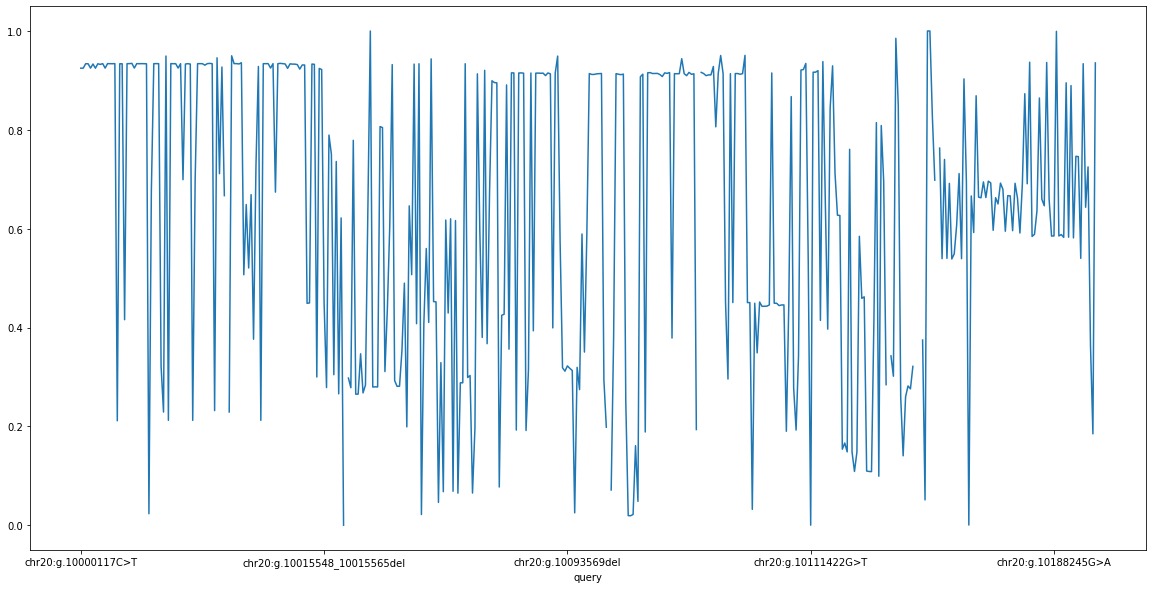

In [46]:
df["gnomad_genome.af.af_popmax"].plot(figsize=(20,10))

In [47]:
df.groupby(['dbsnp.gene.name']).count()

,_id,_version,chrom,observed,cadd.1000g.af,cadd.1000g.afr,cadd.1000g.amr,cadd.1000g.asn,cadd.1000g.eur,cadd._license,cadd.alt,cadd.anc,cadd.annotype,cadd.bstatistic,cadd.chmm.bivflnk,cadd.chmm.enh,cadd.chmm.enhbiv,cadd.chmm.het,cadd.chmm.quies,cadd.chmm.reprpc,cadd.chmm.reprpcwk,cadd.chmm.tssa,cadd.chmm.tssaflnk,cadd.chmm.tssbiv,cadd.chmm.tx,cadd.chmm.txflnk,cadd.chmm.txwk,cadd.chmm.znfrpts,cadd.chrom,cadd.consdetail,cadd.consequence,cadd.consscore,cadd.cpg,cadd.dna.helt,cadd.dna.mgw,cadd.dna.prot,cadd.dna.roll,cadd.encode.h3k27ac,cadd.encode.h3k4me1,cadd.encode.h3k4me3,cadd.encode.nucleo,cadd.fitcons,cadd.gc,cadd.gene,cadd.gerp.n,cadd.gerp.s,cadd.isderived,cadd.isknownvariant,cadd.istv,cadd.length,cadd.mapability.20bp,cadd.mapability.35bp,cadd.min_dist_tse,cadd.min_dist_tss,cadd.mutindex,cadd.phast_cons.mammalian,cadd.phast_cons.primate,cadd.phast_cons.vertebrate,cadd.phred,cadd.phylop.mammalian,cadd.phylop.primate,cadd.phylop.vertebrate,cadd.pos,cadd.rawscore,cadd.ref,cadd.segway,cadd.type,dbsnp._license,dbsnp.alleles,dbsnp.alt,dbsnp.chrom,dbsnp.dbsnp_build,dbsnp.dbsnp_merges,dbsnp.hg19.end,dbsnp.hg19.start,dbsnp.ref,dbsnp.rsid,dbsnp.vartype,gnomad_genome._license,gnomad_genome.ac.ac,gnomad_genome.ac.ac_afr,gnomad_genome.ac.ac_afr_female,gnomad_genome.ac.ac_afr_male,gnomad_genome.ac.ac_amr,gnomad_genome.ac.ac_amr_female,gnomad_genome.ac.ac_amr_male,gnomad_genome.ac.ac_asj,gnomad_genome.ac.ac_asj_female,gnomad_genome.ac.ac_asj_male,gnomad_genome.ac.ac_eas,gnomad_genome.ac.ac_eas_female,gnomad_genome.ac.ac_eas_male,gnomad_genome.ac.ac_female,gnomad_genome.ac.ac_fin,gnomad_genome.ac.ac_fin_female,gnomad_genome.ac.ac_fin_male,gnomad_genome.ac.ac_male,gnomad_genome.ac.ac_nfe,gnomad_genome.ac.ac_nfe_est,gnomad_genome.ac.ac_nfe_female,gnomad_genome.ac.ac_nfe_male,gnomad_genome.ac.ac_nfe_nwe,gnomad_genome.ac.ac_nfe_onf,gnomad_genome.ac.ac_nfe_seu,gnomad_genome.ac.ac_oth,gnomad_genome.ac.ac_oth_female,gnomad_genome.ac.ac_oth_male,gnomad_genome.ac.ac_popmax,gnomad_genome.ac.ac_raw,gnomad_genome.af.af,gnomad_genome.af.af_afr,gnomad_genome.af.af_afr_female,gnomad_genome.af.af_afr_male,gnomad_genome.af.af_amr,gnomad_genome.af.af_amr_female,gnomad_genome.af.af_amr_male,gnomad_genome.af.af_asj,gnomad_genome.af.af_asj_female,gnomad_genome.af.af_asj_male,gnomad_genome.af.af_eas,gnomad_genome.af.af_eas_female,gnomad_genome.af.af_eas_male,gnomad_genome.af.af_female,gnomad_genome.af.af_fin,gnomad_genome.af.af_fin_female,gnomad_genome.af.af_fin_male,gnomad_genome.af.af_male,gnomad_genome.af.af_nfe,gnomad_genome.af.af_nfe_est,gnomad_genome.af.af_nfe_female,gnomad_genome.af.af_nfe_male,gnomad_genome.af.af_nfe_nwe,gnomad_genome.af.af_nfe_onf,gnomad_genome.af.af_nfe_seu,gnomad_genome.af.af_oth,gnomad_genome.af.af_oth_female,gnomad_genome.af.af_oth_male,gnomad_genome.af.af_popmax,gnomad_genome.af.af_raw,gnomad_genome.alleles,gnomad_genome.alt,gnomad_genome.an.an,gnomad_genome.an.an_afr,gnomad_genome.an.an_afr_female,gnomad_genome.an.an_afr_male,gnomad_genome.an.an_amr,gnomad_genome.an.an_amr_female,gnomad_genome.an.an_amr_male,gnomad_genome.an.an_asj,gnomad_genome.an.an_asj_female,gnomad_genome.an.an_asj_male,gnomad_genome.an.an_eas,gnomad_genome.an.an_eas_female,gnomad_genome.an.an_eas_male,gnomad_genome.an.an_female,gnomad_genome.an.an_fin,gnomad_genome.an.an_fin_female,gnomad_genome.an.an_fin_male,gnomad_genome.an.an_male,gnomad_genome.an.an_nfe,gnomad_genome.an.an_nfe_est,gnomad_genome.an.an_nfe_female,gnomad_genome.an.an_nfe_male,gnomad_genome.an.an_nfe_nwe,gnomad_genome.an.an_nfe_onf,gnomad_genome.an.an_nfe_seu,gnomad_genome.an.an_oth,gnomad_genome.an.an_oth_female,gnomad_genome.an.an_oth_male,gnomad_genome.an.an_popmax,gnomad_genome.an.an_raw,gnomad_genome.baseqranksum,gnomad_genome.chrom,gnomad_genome.clippingranksum,gnomad_genome.fs,gnomad_genome.hom.hom,gnomad_genome.hom.hom_afr,gnomad_genome.hom.hom_afr_female,gnomad_genome.hom.hom_afr_male,gnomad_genome.hom.hom_amr,gnomad_genome.hom.hom_amr_female,gnomad_genome.hom.hom_amr_male,gnomad_gen